In [1]:
!pip install pyspark
!pip install sparknlp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 697.1/697.1 kB 18.2 MB/s eta 0:00:00


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, corr

spark = SparkSession.builder \
    .appName("YouTube Video Analysis") \
    .getOrCreate()

df = spark.read.csv('/content/USvideos.csv', header=True, inferSchema=True)
dff = df.withColumn("views", col("views").cast("int"))
dff = dff.withColumn("likes", col("likes").cast("int"))
dff = dff.withColumn("dislikes", col("dislikes").cast("int"))
dff = dff.withColumn("comment_count", col("comment_count").cast("int"))

nulls_removed = dff.dropna(subset=['video_id', 'category_id', 'comment_count'])

p_df = nulls_removed.dropDuplicates(['video_id'])


p_df = p_df.fillna({'views': 1, 'likes': 1, 'dislikes': 1})

correlation_columns = ['likes', 'dislikes', 'comment_count']
for col_name in correlation_columns:
    correlation = p_df.select(corr('views', col_name)).collect()[0][0]
    print(f"Correlation between views and {col_name}: {correlation}")


Correlation between views and likes: 0.7611271072614448
Correlation between views and dislikes: 0.3961349735157359
Correlation between views and comment_count: 0.5996278101199168


In [3]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator


selected_features = ['likes', 'dislikes', 'comment_count']


assembler = VectorAssembler(inputCols=selected_features, outputCol="features")
dfff = assembler.transform(p_df)


data = dfff.select("features", "views")
train_data, test_data = data.randomSplit([0.8, 0.2], seed=1234)

lr = LinearRegression(labelCol="views")
rf = RandomForestRegressor(labelCol="views")

lr_model = lr.fit(train_data)
rf_model = rf.fit(train_data)

lr_predictions = lr_model.transform(test_data)
rf_predictions = rf_model.transform(test_data)

evaluator = RegressionEvaluator(labelCol="views", metricName="rmse")
lr_rmse = evaluator.evaluate(lr_predictions)
rf_rmse = evaluator.evaluate(rf_predictions)

print(f"Linear Regression RMSE: {lr_rmse}")
print(f"Random Forest RMSE: {rf_rmse}")


Linear Regression RMSE: 1157099.150775443
Random Forest RMSE: 1103480.4916524005


In [4]:
from pyspark.sql.functions import mean, lit

mean_views_value = p_df.agg(mean('views')).first()[0]

baseline_predictions = test_data.withColumn("prediction", lit(mean_views_value))

baseline_rmse = evaluator.evaluate(baseline_predictions)

print(f"Baseline RMSE: {baseline_rmse}")

checklr=lr_rmse-baseline_rmse
checkrf=rf_rmse-baseline_rmse

print(f"lr={checklr},   rf={checkrf}")

#thus our models are lower than the baseline so they are good to use a prediction models



Baseline RMSE: 1845477.5290366374
lr=-688378.3782611943,   rf=-741997.0373842369


In [5]:
lr_predictions.select('features', 'views', 'prediction').show(5)
rf_predictions.select('features', 'views', 'prediction').show(5)



+---------------+------+-----------------+
|       features| views|       prediction|
+---------------+------+-----------------+
|      (3,[],[])|  2259|298063.3719524592|
|      (3,[],[])| 15058|298063.3719524592|
| [0.0,0.0,95.0]| 84013|295040.7801300511|
|[0.0,0.0,619.0]|134817|278368.7999727682|
|[0.0,0.0,863.0]| 23795| 270605.511502583|
+---------------+------+-----------------+
only showing top 5 rows

+---------------+------+------------------+
|       features| views|        prediction|
+---------------+------+------------------+
|      (3,[],[])|  2259| 155217.0732921586|
|      (3,[],[])| 15058| 155217.0732921586|
| [0.0,0.0,95.0]| 84013|157806.82717440237|
|[0.0,0.0,619.0]|134817|177269.27174191872|
|[0.0,0.0,863.0]| 23795|205892.48858860816|
+---------------+------+------------------+
only showing top 5 rows



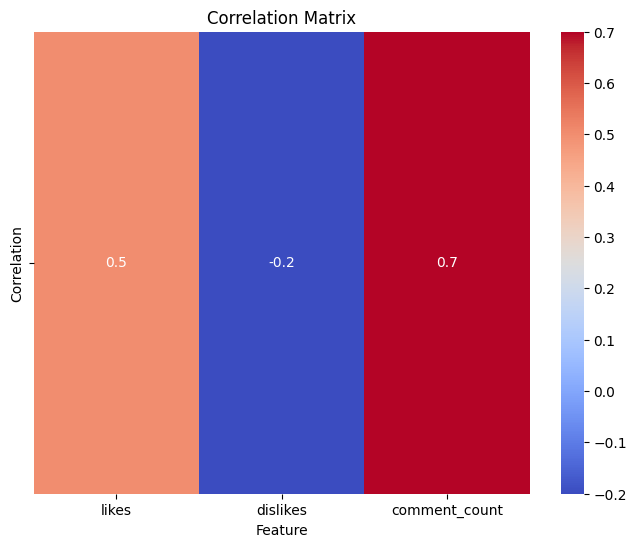

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


correlation_data = {'Feature': ['likes', 'dislikes', 'comment_count'], 'Correlation': [0.5, -0.2, 0.7]}  # Replace with actual values
correlation_df = pd.DataFrame(correlation_data)
correlation_matrix = correlation_df.set_index('Feature').T

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


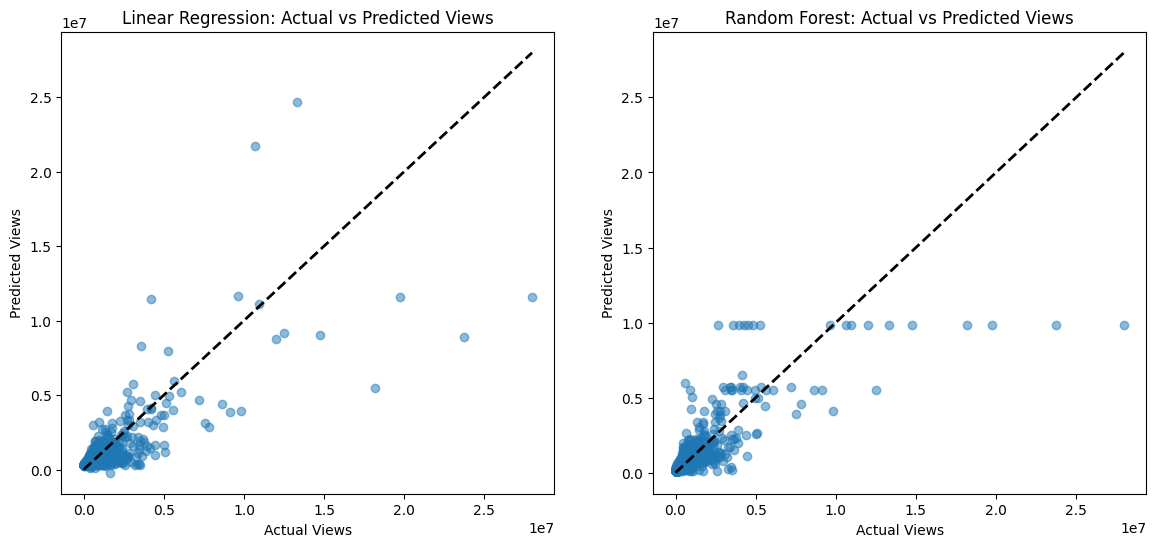

In [7]:
import matplotlib.pyplot as plt

# Convert the predictions and actual values to Pandas DataFrame
lr_predictions_df = lr_predictions.select('prediction', 'views').toPandas()
rf_predictions_df = rf_predictions.select('prediction', 'views').toPandas()

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(lr_predictions_df['views'], lr_predictions_df['prediction'], alpha=0.5)
plt.plot([lr_predictions_df['views'].min(), lr_predictions_df['views'].max()],
         [lr_predictions_df['views'].min(), lr_predictions_df['views'].max()], 'k--', lw=2)
plt.xlabel('Actual Views')
plt.ylabel('Predicted Views')
plt.title('Linear Regression: Actual vs Predicted Views')

plt.subplot(1, 2, 2)
plt.scatter(rf_predictions_df['views'], rf_predictions_df['prediction'], alpha=0.5)
plt.plot([rf_predictions_df['views'].min(), rf_predictions_df['views'].max()],
         [rf_predictions_df['views'].min(), rf_predictions_df['views'].max()], 'k--', lw=2)
plt.xlabel('Actual Views')
plt.ylabel('Predicted Views')
plt.title('Random Forest: Actual vs Predicted Views')

#plt.tight_layout()
plt.show()


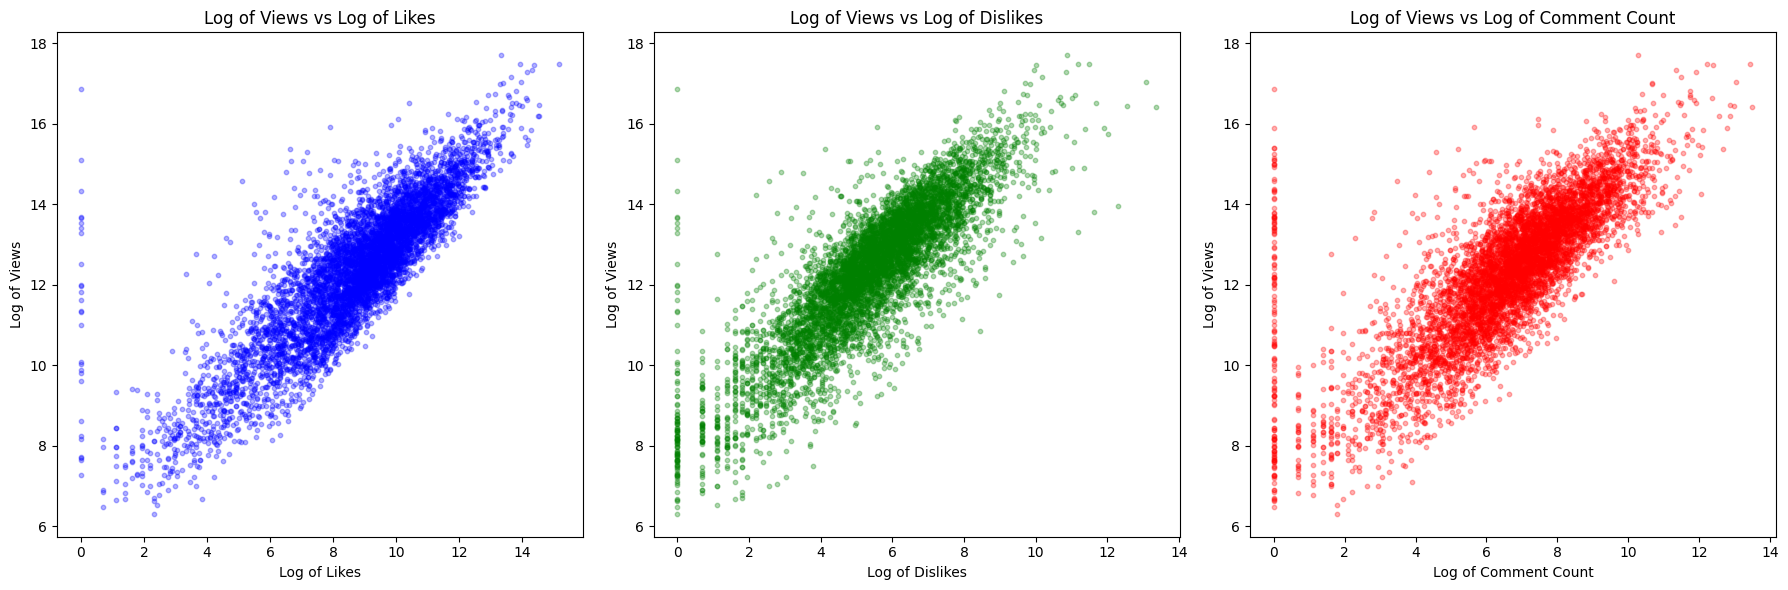

In [8]:
import numpy as np
import matplotlib.pyplot as plt

p_df = p_df.toPandas()


# Apply log transformation to 'views' and the features
p_df['log_views'] = np.log1p(p_df['views'])
p_df['log_likes'] = np.log1p(p_df['likes'])
p_df['log_dislikes'] = np.log1p(p_df['dislikes'])
p_df['log_comment_count'] = np.log1p(p_df['comment_count'])

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.scatter(p_df['log_likes'], p_df['log_views'], alpha=0.3, s=10, c='blue')
plt.xlabel('Log of Likes')
plt.ylabel('Log of Views')
plt.title('Log of Views vs Log of Likes')

plt.subplot(1, 3, 2)
plt.scatter(p_df['log_dislikes'], p_df['log_views'], alpha=0.3, s=10, c='green')
plt.xlabel('Log of Dislikes')
plt.ylabel('Log of Views')
plt.title('Log of Views vs Log of Dislikes')

plt.subplot(1, 3, 3)
plt.scatter(p_df['log_comment_count'], p_df['log_views'], alpha=0.3, s=10, c='red')
plt.xlabel('Log of Comment Count')
plt.ylabel('Log of Views')
plt.title('Log of Views vs Log of Comment Count')

plt.tight_layout()
plt.show()
